In [2]:
from preamble import *
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
df = pd.read_csv('./data/j_before_feature_importance.csv')

In [4]:
def create_sequences(data, seq_length, target_length):
  Xs = []
  ys = []
  for i in range(len(data) - seq_length - target_length + 1):
    X = data[i:(i + seq_length)].drop('outflow', axis=1).values
    y = data['outflow'].values[i + seq_length: i+ seq_length + target_length]
    Xs.append(X)
    ys.append(y)
  return np.array(Xs), np.array(ys)

In [5]:
SEQ_LENGTH = 168  # 과거 7일 (시간 단위)
TARGET_LENGTH = 1 # 이후 1시간 예측

X, y = create_sequences(df, SEQ_LENGTH, TARGET_LENGTH)

In [6]:
train_size = int(len(X) * 0.7)
valid_size = int(train_size * 0.1)

X_train, X_test = X[:(train_size - valid_size)], X[train_size:]
X_valid, y_valid = X[(train_size - valid_size):train_size], y[(train_size - valid_size):train_size]
y_train, y_test = y[:(train_size - valid_size)], y[train_size:]

print(X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_valid.shape, y_test.shape)

(9674, 168, 32) (4607, 168, 32) (1074, 168, 32) (9674, 1) (1074, 1) (4607, 1)


In [6]:
import xgboost as xgb

def get_feature_importance(X_train, y_train, X_valid, y_valid, feature_names):
  reg = xgb.XGBRegressor(n_estimators=1000, eval_metric="rmse", random_state=1021, early_stopping_rounds=25)
  reg.fit(
    X_train.reshape(X_train.shape[0], -1), 
    y_train.reshape(-1),
    eval_set=[(X_valid.reshape(X_valid.shape[0], -1), y_valid.reshape(-1))],
    verbose=10,
  )
  feature_importances = reg.feature_importances_
  
  # 순서에 맞게 feature name을 확장
  feature_names_extended = []
  for i in range(SEQ_LENGTH):
    for name in feature_names:
      feature_names_extended.append(f"{name}_t-{SEQ_LENGTH-i-1}")
          
  importance_df = pd.DataFrame({'Feature': feature_names_extended, 'Importance': feature_importances})
  importance_df = importance_df.sort_values('Importance', ascending=False)
  return reg, importance_df

In [7]:
feature_names = df.drop('outflow', axis=1).columns
reg_all, importance_df = get_feature_importance(X_train, y_train, X_valid, y_valid, feature_names)

[0]	validation_0-rmse:2007.90261
[10]	validation_0-rmse:1222.75470
[20]	validation_0-rmse:1209.28441
[30]	validation_0-rmse:1216.90246
[40]	validation_0-rmse:1231.06637
[41]	validation_0-rmse:1231.71829


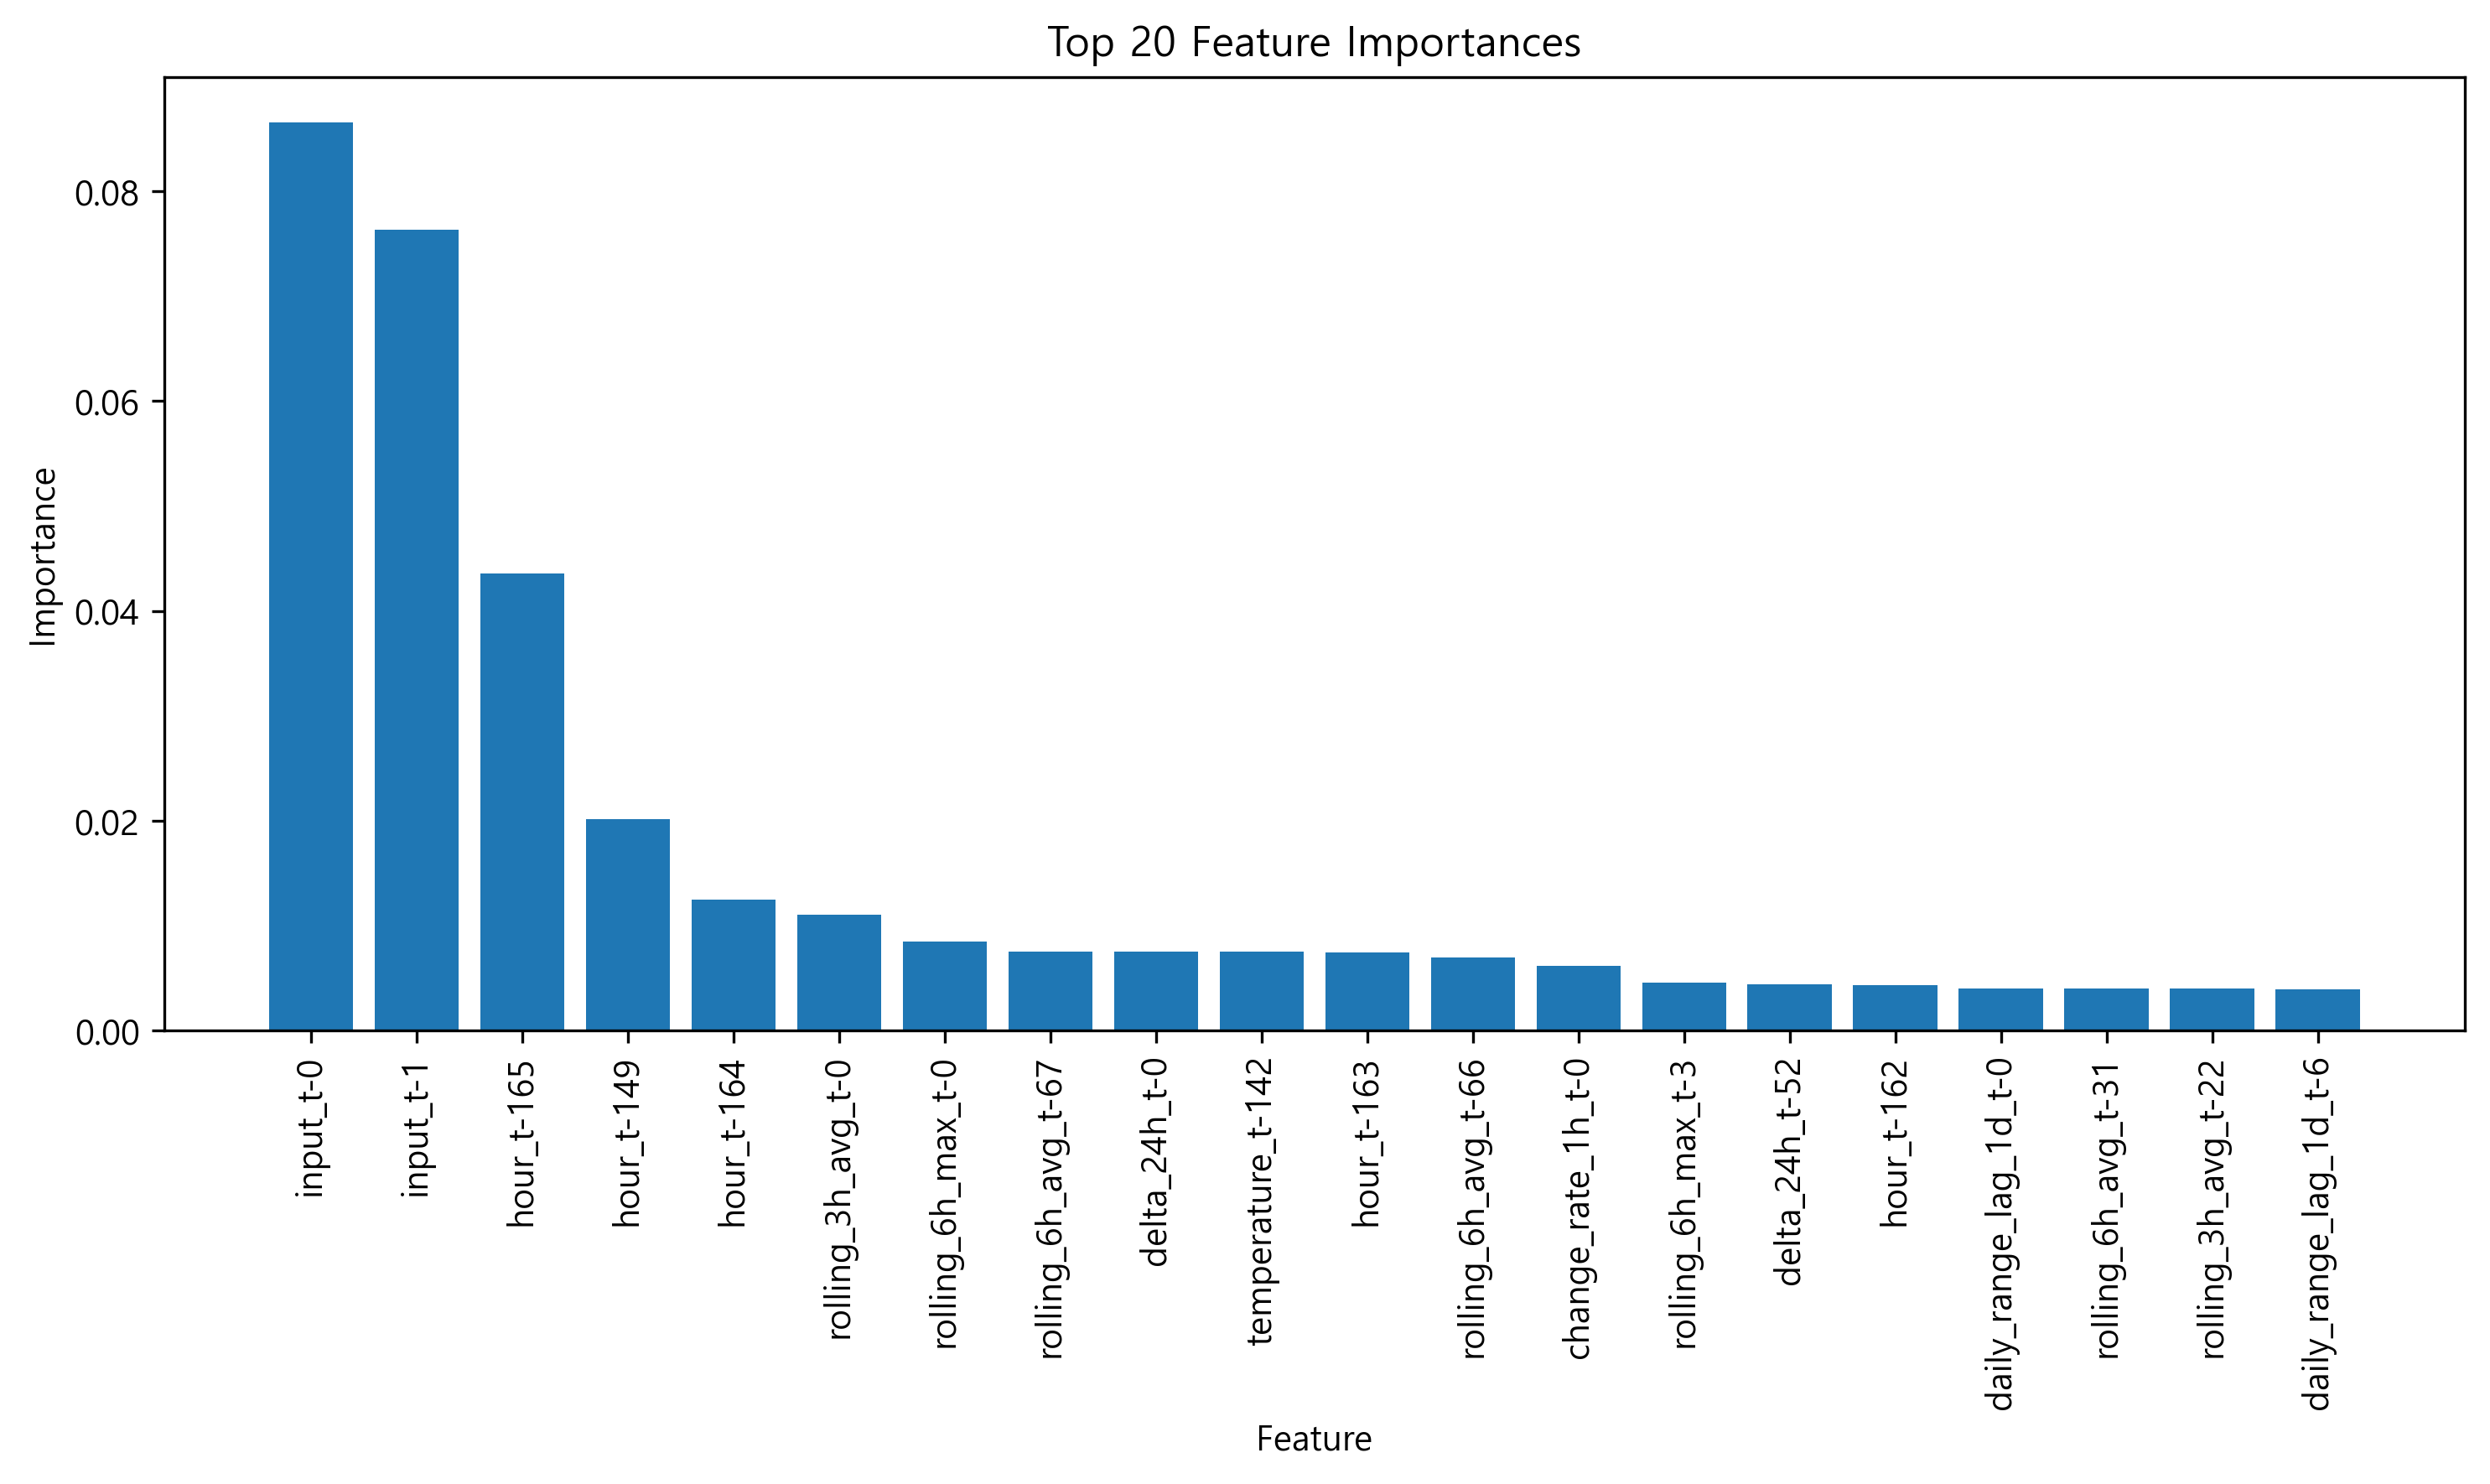

In [8]:
# 중요도 시각화 (상위 N개만)
N = 20 
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'][:N], importance_df['Importance'][:N])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top {} Feature Importances'.format(N))
plt.tight_layout()
plt.show()

In [9]:
# 중요도가 평균 이상인 feature만 선택
mean_importance = importance_df['Importance'].mean()
selected_features = importance_df[importance_df['Importance'] >= mean_importance]['Feature'].tolist()
print(f"Number of features selected: {len(selected_features)}")

Number of features selected: 989


In [10]:
def select_features(X, selected_features, feature_names, seq_length):
  selected_indices = []
  num_features = len(feature_names)
  total_features = seq_length * num_features  # 전체 feature 수 (time step * feature)

  for feature in selected_features:
    feature_name, time_lag_str = feature.split('_t-')
    time_lag = int(time_lag_str)
    feature_index = feature_names.get_loc(feature_name)

    # time lag에 따른 offset 계산
    time_offset = time_lag * num_features
    
    # 최종 인덱스 계산 (feature 시작 위치 + feature_index)
    index = total_features - time_offset - num_features + feature_index #  역순으로

    if index >= X.shape[2] or index < 0:
      print(f"Warning: Index {index} out of bounds for feature {feature}. Skipping.")
      continue
    selected_indices.append(index)

  return X[:, :, selected_indices]

In [11]:
X_train_selected = select_features(X_train, selected_features, feature_names, SEQ_LENGTH)
X_valid_selected = select_features(X_valid, selected_features, feature_names, SEQ_LENGTH)
X_test_selected = select_features(X_test, selected_features, feature_names, SEQ_LENGTH)

print("Selected feature X train shape:", X_train_selected.shape)
print("Selected feature X valid shape:", X_valid_selected.shape)
print("Selected feature X test shape:", X_test_selected.shape)

Selected feature X train shape: (9674, 168, 7)
Selected feature X valid shape: (1074, 168, 7)
Selected feature X test shape: (4607, 168, 7)


In [31]:
reg_selected = xgb.XGBRegressor(n_estimators=1000, eval_metric="rmse", random_state=1021, early_stopping_rounds=25)
reg_selected.fit(
  X_train_selected.reshape(X_train_selected.shape[0], -1), 
  y_train.reshape(-1),
  eval_set=[(X_valid_selected.reshape(X_valid_selected.shape[0], -1), y_valid.reshape(-1))],
  verbose=10,
)

[0]	validation_0-rmse:2085.89206
[10]	validation_0-rmse:1431.11884
[20]	validation_0-rmse:1436.20241
[30]	validation_0-rmse:1437.65337
[37]	validation_0-rmse:1442.33619


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=25,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=1021, ...)

In [13]:
y_pred_selected = reg_selected.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_selected))

print(f"Test RMSE with selected features: {rmse_selected}")

y_pred_all = reg_all.predict(X_test.reshape(X_test.shape[0], -1))
rmse_all = np.sqrt(mean_squared_error(y_test, y_pred_all))

print(f"Test RMSE with all features: {rmse_all}")

Test RMSE with selected features: 1534.3167348375937
Test RMSE with all features: 1499.1792705326693


In [14]:
def evaluate_model_cv(X, y, n_splits=5):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  rmse_scores = []
  
  for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]
    
    reg_cv = xgb.XGBRegressor(n_estimators=1000, eval_metric="rmse", random_state=42)
    reg_cv.fit(
      X_train_cv.reshape(X_train_cv.shape[0], -1), 
      y_train_cv.reshape(-1),
      eval_set=[(X_val_cv.reshape(X_val_cv.shape[0], -1), y_val_cv.reshape(-1))],
      verbose=False,
      early_stopping_rounds=50
    )
    
    y_pred_cv = reg_cv.predict(X_val_cv.reshape(X_val_cv.shape[0], -1))
    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    rmse_scores.append(rmse_cv)
      
  return np.mean(rmse_scores)

# # 선택된 feature로 교차 검증 수행
# rmse_cv_selected = evaluate_model_cv(X_train_selected, y_train)
# print(f"Cross-validation RMSE with selected features: {rmse_cv_selected}")

# # 모든 feature로 교차 검증 수행
# rmse_cv_all = evaluate_model_cv(X_train, y_train)
# print(f"Cross-validation RMSE with all features: {rmse_cv_all}")

In [15]:
model_filename = './model/1hour_xgboost_selected_features_model.json'
reg_selected.save_model(model_filename)

In [7]:
model_filename2 = './model/1hour_xgboost_all_features_model.json'
reg_all.save_model(model_filename2)

NameError: name 'reg_all' is not defined

In [8]:
model = xgb.Booster(model_file=model_filename2)

In [9]:
data = pd.read_csv('./data/j_before_feature_importance_with_datetime.csv')

In [10]:
# 예측을 위한 DMatrix 생성
dtest = xgb.DMatrix(X_test.reshape(X_test.shape[0], -1))

# 예측 수행
y_pred = model.predict(dtest)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAPE: {mape:.4f}%')
print(f'Test R-squared: {r2:.4f}')

Test RMSE: 1512.5276
Test MAPE: 30.0959%
Test R-squared: 0.6511


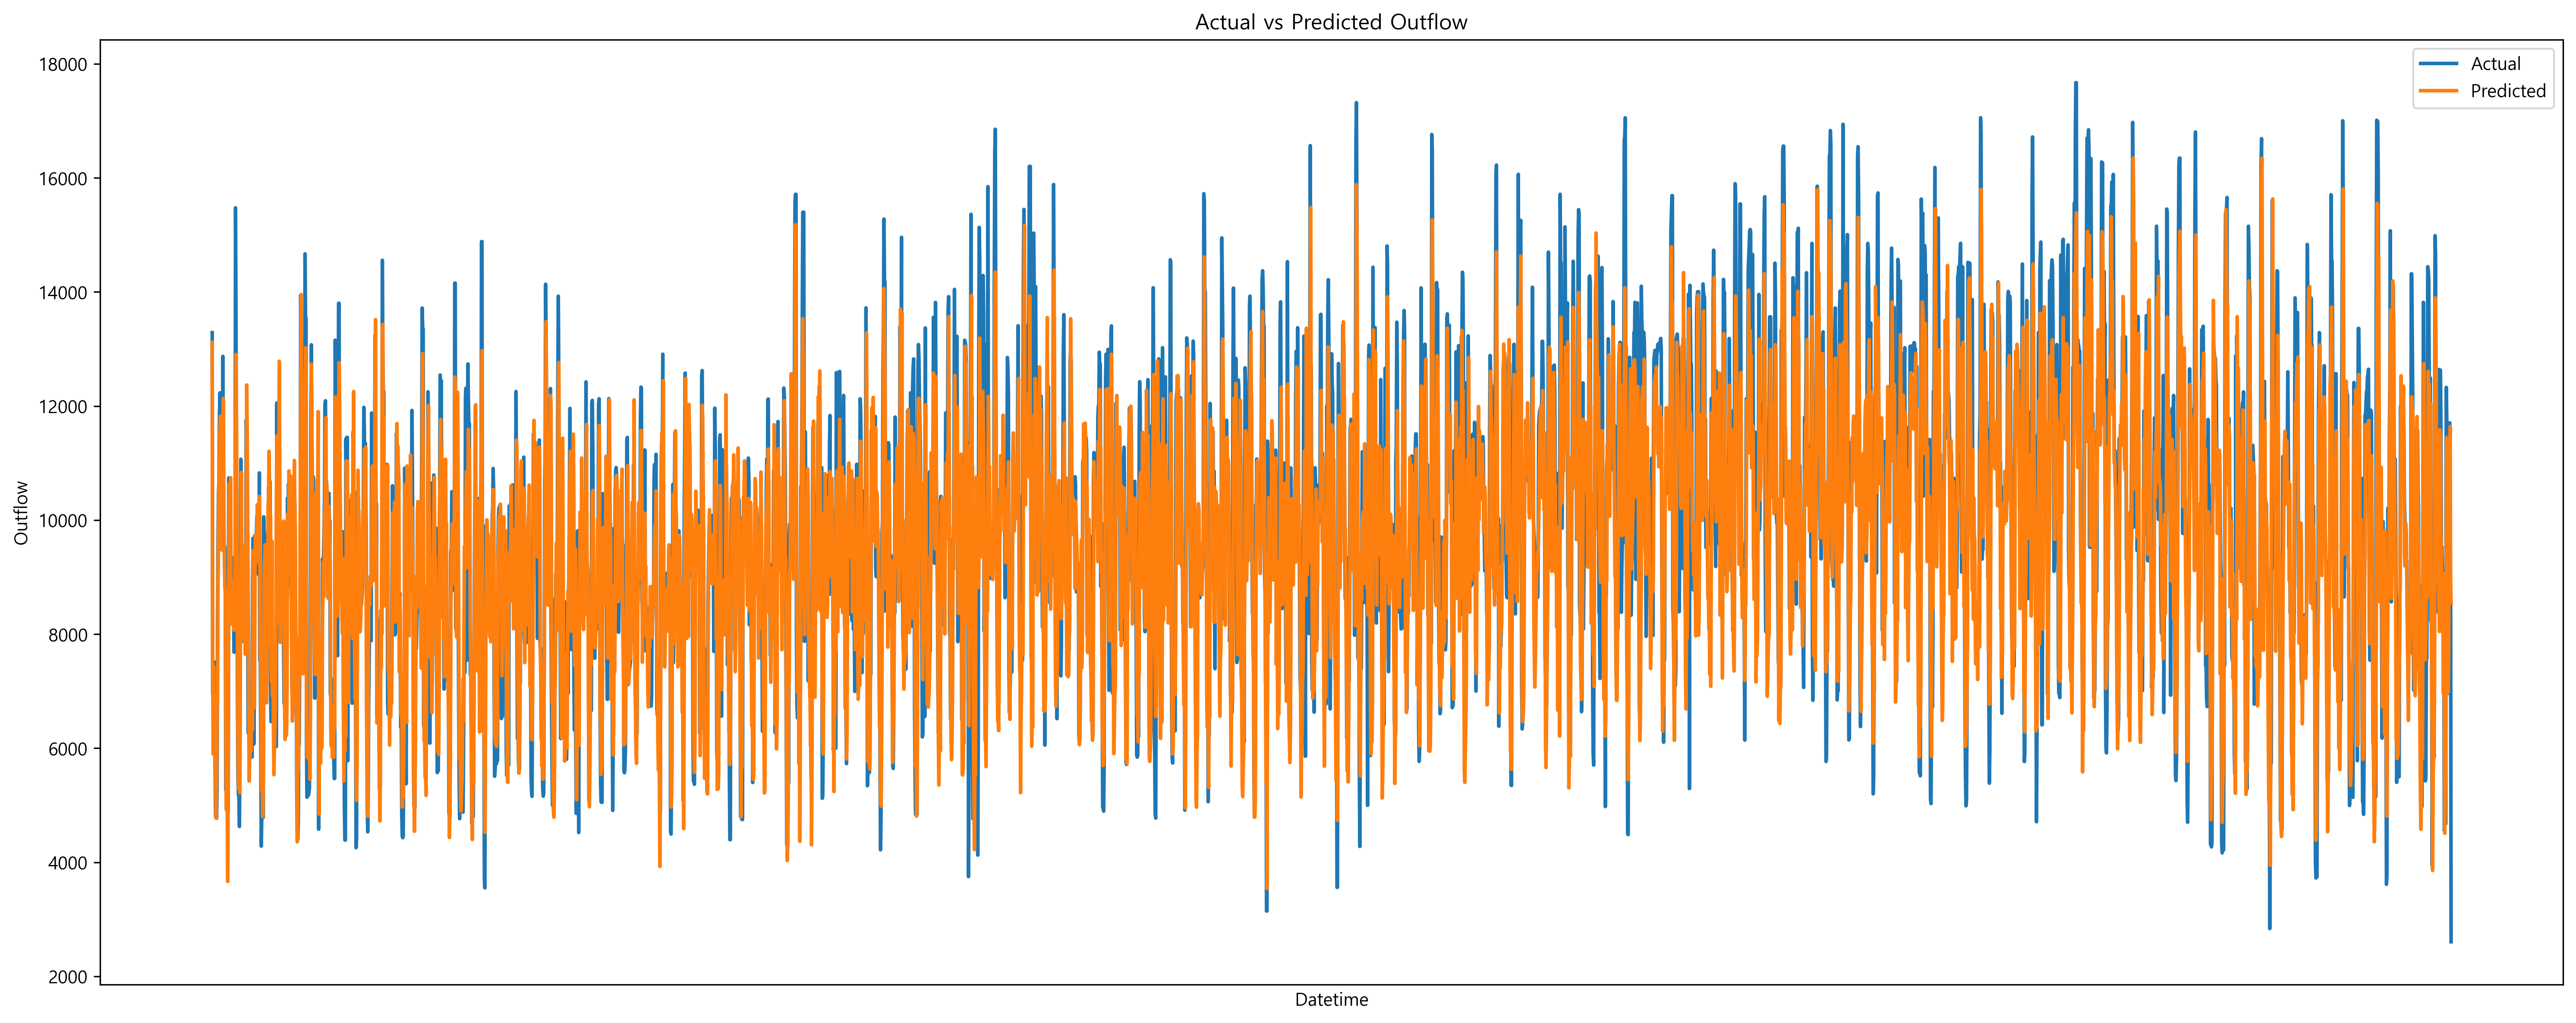

In [ ]:
# 시각화
plt.figure(figsize=(20, 8))

# datetime 정보 추출
start_index = train_size + SEQ_LENGTH  # X_test 시작 위치
end_index = start_index + len(y_test) # X_test 끝 위치

# datetime 범위 생성
datetime_range = data['datetime'][start_index:end_index].values
if len(datetime_range) < len(y_pred):
  print("Warning: Datetime range is shorter than prediction length. Adjusting range.")
  y_pred = y_pred[:len(datetime_range)]

# y_test의 범위도 조정
y_test_plot = y_test[:len(datetime_range)]

# 시각화
plt.plot(datetime_range, y_test_plot, label='Actual')
plt.plot(datetime_range, y_pred, label='Predicted')

plt.xticks([])  # x축 눈금 제거
plt.xlabel('Datetime')
plt.ylabel('Outflow')
plt.title('Actual vs Predicted Outflow')
plt.legend()
plt.tight_layout()        # 레이아웃 조정
plt.show()

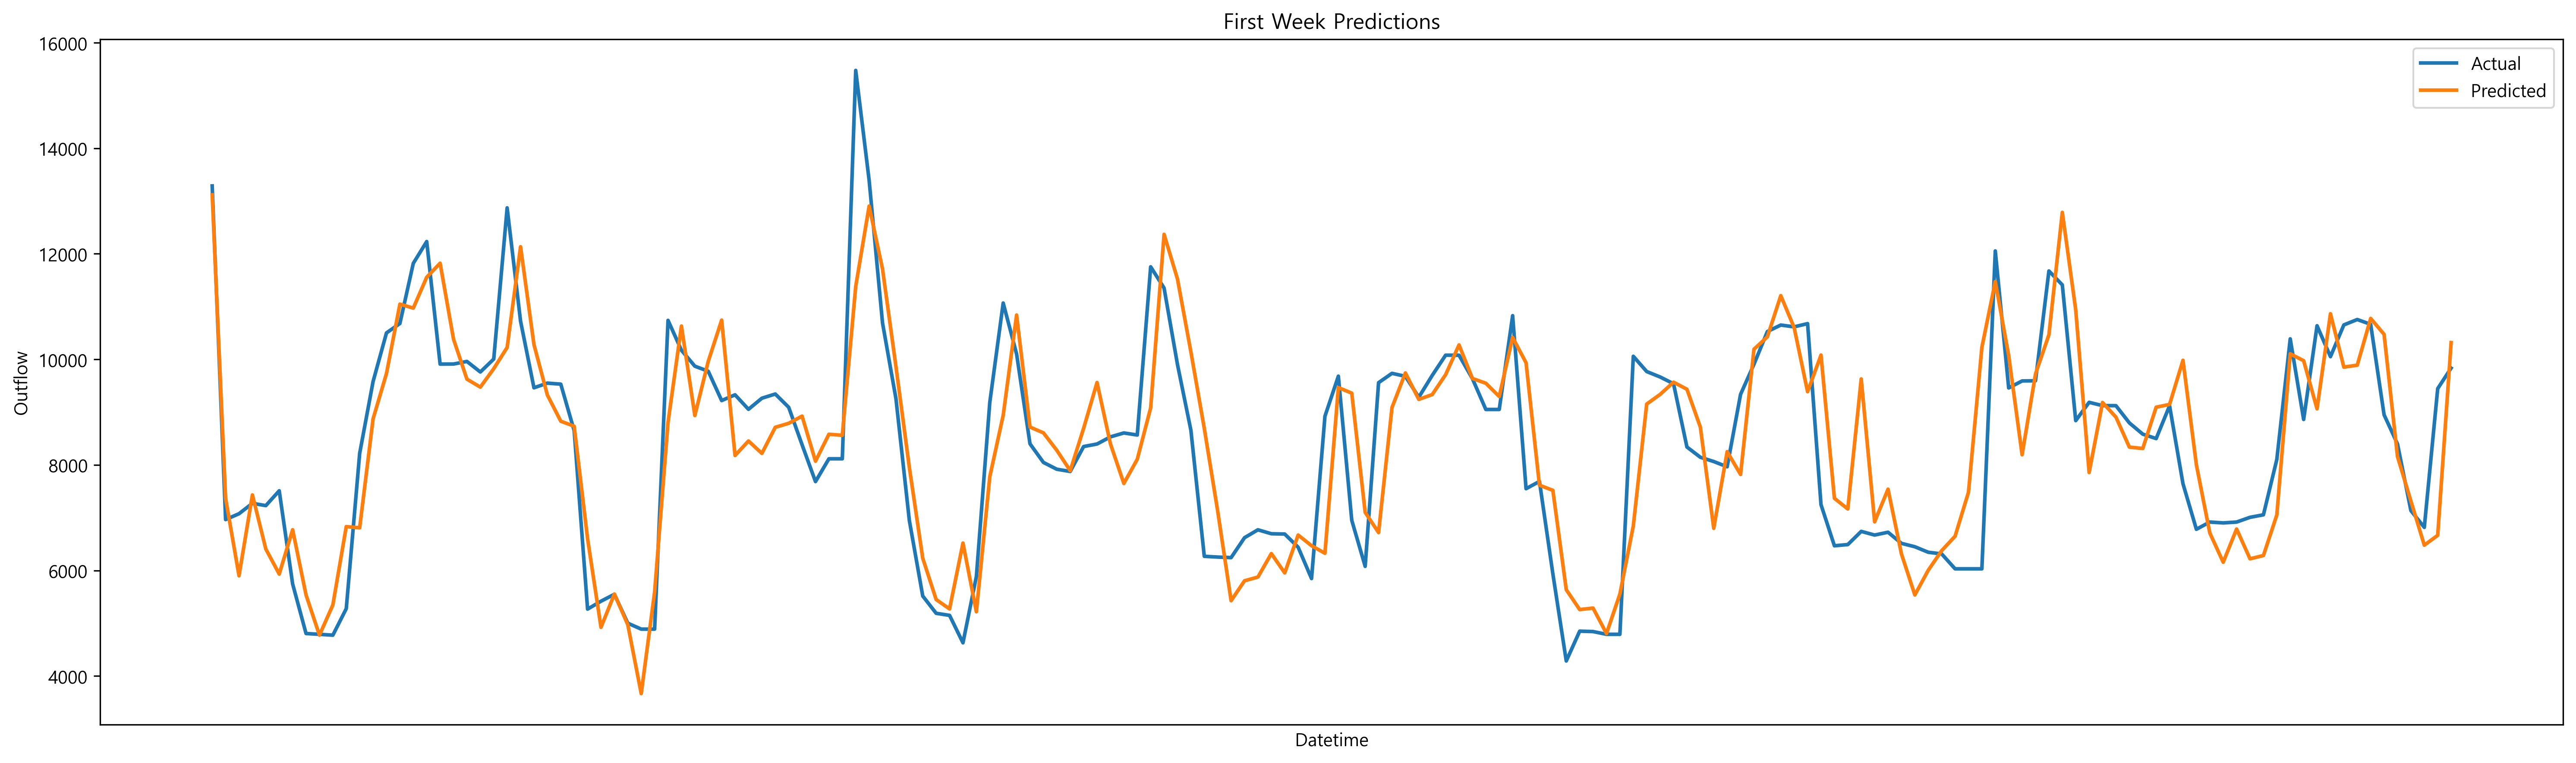

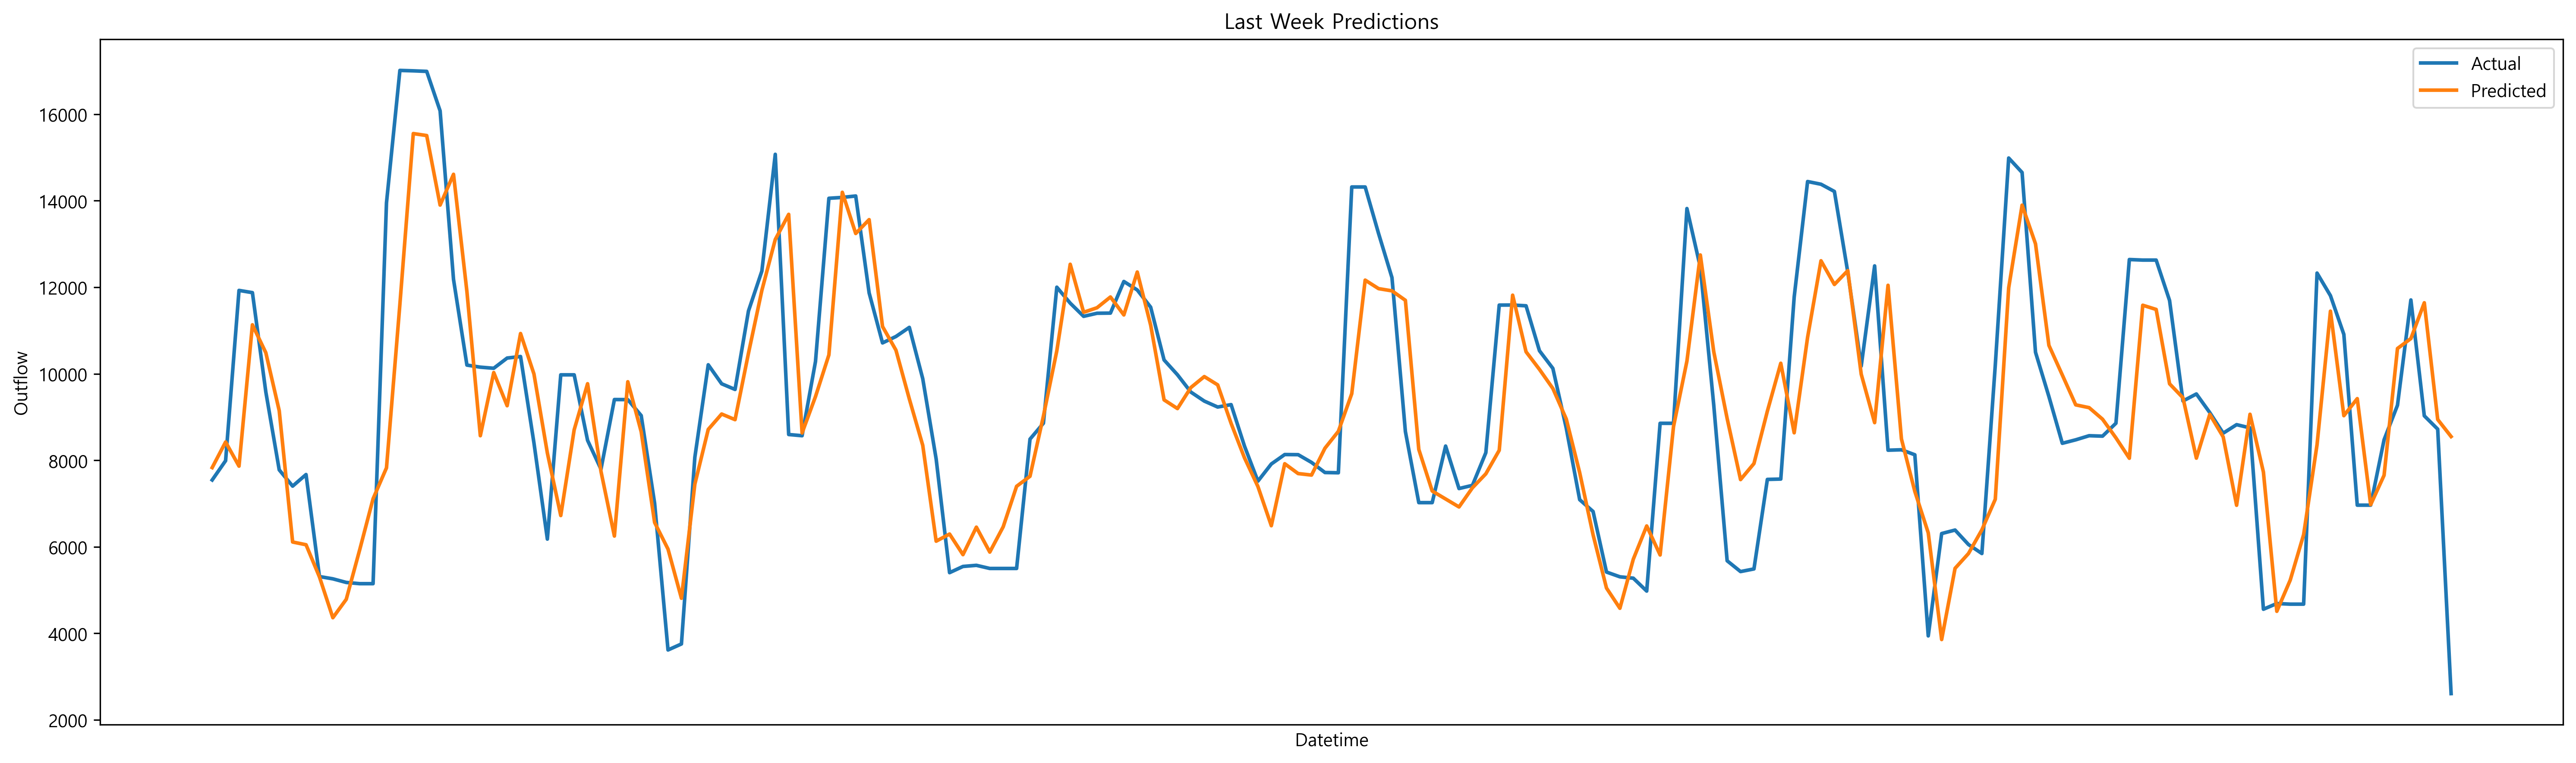

In [30]:
def plot_predictions_weekly(y_true, y_pred, datetime_data, start_index, plot_title):
  plt.figure(figsize=(20, 6))

  # datetime 범위 추출
  datetime_range = datetime_data[start_index:start_index + 168].values  # 일주일 (168시간)

  # 예측값과 실제값 범위 조정
  y_true_plot = y_true[:168]
  y_pred_plot = y_pred[:168]

  plt.plot(y_true_plot, label='Actual')
  plt.plot(y_pred_plot, label='Predicted')

  plt.xlabel('Datetime')
  plt.ylabel('Outflow')
  plt.title(plot_title)
  plt.legend()
  plt.xticks([])  # x축 레이블 생략
  plt.tight_layout()
  plt.show()

# 초반 일주일 시각화
start_index_start = train_size + SEQ_LENGTH
plot_predictions_weekly(y_test, y_pred, data['datetime'], start_index_start, 'First Week Predictions')

# 마지막 일주일 시각화
start_index_end = train_size + SEQ_LENGTH + len(y_test) - 168 # 마지막 168시간을 맞추기 위해 index 조정
plot_predictions_weekly(y_test[-168:], y_pred[-168:], data['datetime'], len(data) - 168, 'Last Week Predictions')